In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path_regression_data = r'regression.csv'
table_df = pd.read_csv(path_regression_data)
target = table_df['Y']
data_df = table_df.drop('Y', axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Besoin de mélanger les rows? Pas de dépendances temporelles a priori
X_train_val, X_test, y_train_val, y_test = train_test_split(data_df.values, target.values, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(data_df.values, target.values, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

class Subset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.y = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


BATCH_SIZE = 256
SEED = 42



# generate subset based on indices
train_split = Subset(X_train_norm, y_train)
val_split  = Subset(X_val_norm, y_val)
test_split = Subset(X_test_norm, y_test)


train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_batches = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE)

## Classement des modèles par ordre de performances

### Modèle le plus large ~10k paramètres

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10, 128)  
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)  
        x = self.fc3(x)      
        return x

model = MLP()
summary(model, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  1,408
├─Linear: 1-2                            [1, 64]                   8,256
├─Linear: 1-3                            [1, 1]                    65
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [4]:
import torch.optim as optim 
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

lr=0.01
model = MLP()
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
num_epochs = 500

start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
log_dir = 'run/log_' + str(start_time) + '_epochs_'+ str(num_epochs)+ '_lr_'+ str(lr)  + '_model' 
writer = SummaryWriter(log_dir)

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_batches):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predicted y by passing inputs to the model
        outputs = model(inputs)
        
        # Compute the loss
        targets = targets.view(-1, 1) 
        loss = criterion(outputs, targets)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Print statistics (optional)
        running_loss += loss.item()
    avg_loss = running_loss / len(train_batches)
    writer.add_scalar('Training Loss', avg_loss, epoch)

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_batches:
            outputs = model(inputs)
            outputs_clipped = np.clip(outputs, np.min(target), np.max(target))
            loss = criterion(outputs_clipped, targets.view(-1, 1))
            val_loss += loss.item()
    
    # Average validation loss
    avg_val_loss = val_loss / len(val_batches)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model
        print(f'Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.6f}')
    
    writer.add_scalar('Validation Loss', avg_val_loss, epoch)
    if epoch % 10 == 9:  # Log every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}],  Training Loss: {avg_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
        
writer.close()
print("Training finished.")

Best model saved at epoch 1 with validation loss: 0.237621
Best model saved at epoch 2 with validation loss: 0.028690
Best model saved at epoch 3 with validation loss: 0.013295
Best model saved at epoch 4 with validation loss: 0.006669
Best model saved at epoch 5 with validation loss: 0.004930
Epoch [10/500],  Training Loss: 0.013221, Validation Loss: 0.013703
Best model saved at epoch 11 with validation loss: 0.003431
Best model saved at epoch 14 with validation loss: 0.003111
Best model saved at epoch 18 with validation loss: 0.002973
Best model saved at epoch 20 with validation loss: 0.002753
Epoch [20/500],  Training Loss: 0.011730, Validation Loss: 0.002753
Epoch [30/500],  Training Loss: 0.017868, Validation Loss: 0.004198
Best model saved at epoch 33 with validation loss: 0.001482
Epoch [40/500],  Training Loss: 0.002438, Validation Loss: 0.011014
Best model saved at epoch 47 with validation loss: 0.000757
Epoch [50/500],  Training Loss: 0.004935, Validation Loss: 0.005796
Epoch

In [188]:
def listlisttolist(list_outputs):
        return [elem for sublist in list_outputs for elem in sublist]

def prediction_density(model, set_batch, target, name ='None'):
    model.eval()  # Set the model to evaluation mode
    loss = 0.0
    list_outputs, list_outputs_clipped = [], []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in set_batch:
            outputs = model(inputs)
            outputs_clipped = np.clip(outputs, np.min(target), np.max(target))
            list_outputs.append(outputs.view(-1).numpy())
            list_outputs_clipped.append(outputs_clipped.view(-1).numpy())
            loss = criterion(outputs, targets.view(-1, 1))
            loss += loss.item()

    avg_loss = loss / len(set_batch)
    print(f'Average MSE {name} clipped {avg_loss}')


    list_outputs_merge = listlisttolist(list_outputs)
    list_outputs_clipped_merge = listlisttolist(list_outputs_clipped)


    return avg_loss, list_outputs_merge, list_outputs_clipped_merge

In [189]:
avg_loss_train, list_outputs_train_merge, list_outputs_clipped_train_merge = prediction_density(best_model, train_batches, target, name ='Train')
avg_loss_val, list_outputs_val_merge, list_outputs_clipped_val_merge = prediction_density(best_model, val_batches, target, name ='Val')
avg_loss_test, list_outputs_test_merge, list_outputs_test_clipped_merge = prediction_density(best_model, test_batches, target, name ='Test')

Average MSE Train clipped 7.942042429931462e-06
Average MSE Val clipped 2.4674875021446496e-05
Average MSE Test clipped 3.064324482693337e-05


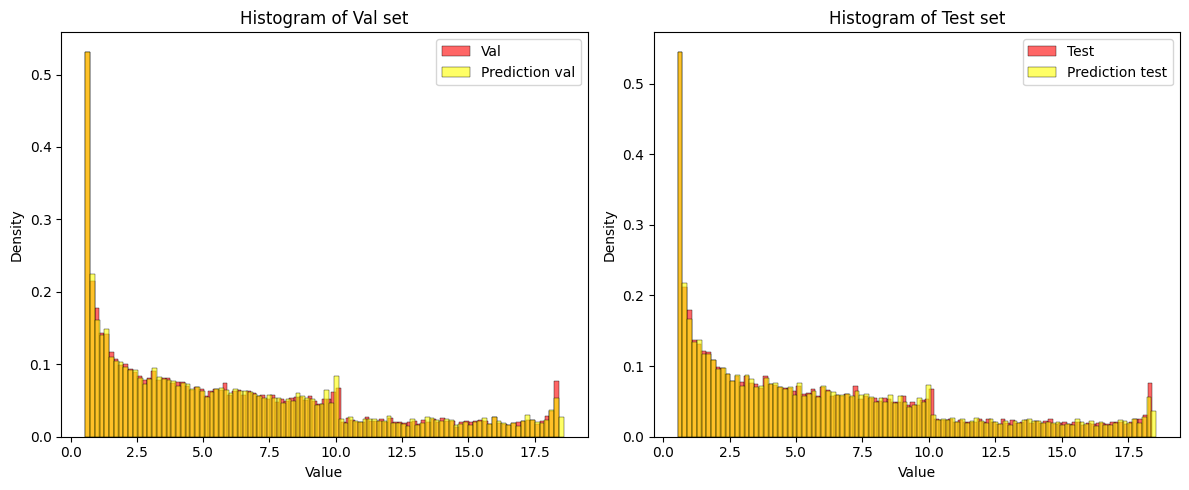

In [190]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(y_val, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Val')
sns.histplot(list_outputs_val_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Prediction val')
#sns.histplot(list_outputs_val_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction train - mse: {round(avg_val_loss,3)}')
ax[0].set_title('Histogram of Val set')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')
ax[0].legend()


sns.histplot(y_test, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label='Test')
sns.histplot(list_outputs_test_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Prediction test')
#sns.histplot(list_outputs_test_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction test - mse: {round(avg_test_loss,3)}')
ax[1].set_title('Histogram of Test set')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Density')
ax[1].legend()

plt.tight_layout()
plt.show()

In [191]:
torch.save(best_model.state_dict(), 'model_weights.pth')
torch.save(best_model, 'model.pth')

In [ ]:
model_loaded = MLP()  
model_loaded.load_state_dict(torch.load('model_weights.pth'))
model_loaded.eval()

In [ ]:
model_loaded = torch.load('model.pth')
model_loaded.eval() 

# Plus petits modèles ~1k paramètres

In [224]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class MLP_small(nn.Module):
    def __init__(self):
        super(MLP_small, self).__init__()
        self.fc1 = nn.Linear(10, 32)   
        self.fc2 = nn.Linear(32, 8)  
        self.fc3 = nn.Linear(8, 1)  

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)   
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01) 
        x = self.fc3(x)      
        return x


model_small = MLP_small()
summary(model_small, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
MLP_small                                [1, 1]                    --
├─Linear: 1-1                            [1, 32]                   352
├─Linear: 1-2                            [1, 8]                    264
├─Linear: 1-3                            [1, 1]                    9
Total params: 625
Trainable params: 625
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [229]:
import torch.optim as optim 
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

lr=0.01
model_small = MLP_small()
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model_small.parameters(), lr=lr)  # Adam optimizer
num_epochs = 500

start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
log_dir = 'run/log_' + str(start_time) + '_epochs_'+ str(num_epochs)+ '_lr_'+ str(lr)  + '_model_small' 
writer = SummaryWriter(log_dir)

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model_small.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_batches):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predicted y by passing inputs to the model
        outputs = model_small(inputs)
        
        # Compute the loss
        targets = targets.view(-1, 1) 
        loss = criterion(outputs, targets)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Print statistics (optional)
        running_loss += loss.item()
    avg_loss = running_loss / len(train_batches)
    writer.add_scalar('Training Loss', avg_loss, epoch)



    model_small.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_batches:
            outputs = model_small(inputs)
            outputs_clipped = np.clip(outputs, np.min(target), np.max(target))
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()
    
    # Average validation loss
    avg_val_loss = val_loss / len(val_batches)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_small = model_small
        print(f'Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.6f}')
    
    writer.add_scalar('Validation Loss', avg_val_loss, epoch)
    if epoch % 10 == 9:  # Log every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}],  Training Loss: {avg_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
        
writer.close()
print("Training finished.")

Best model saved at epoch 1 with validation loss: 1.321073
Best model saved at epoch 2 with validation loss: 0.527881
Best model saved at epoch 3 with validation loss: 0.249657
Best model saved at epoch 4 with validation loss: 0.120182
Best model saved at epoch 5 with validation loss: 0.057807
Best model saved at epoch 6 with validation loss: 0.040410
Best model saved at epoch 7 with validation loss: 0.033775
Best model saved at epoch 10 with validation loss: 0.025364
Epoch [10/500],  Training Loss: 0.032614, Validation Loss: 0.025364
Best model saved at epoch 12 with validation loss: 0.022704
Best model saved at epoch 14 with validation loss: 0.016326
Best model saved at epoch 15 with validation loss: 0.015007
Best model saved at epoch 16 with validation loss: 0.012790
Best model saved at epoch 20 with validation loss: 0.009115
Epoch [20/500],  Training Loss: 0.010722, Validation Loss: 0.009115
Best model saved at epoch 21 with validation loss: 0.007373
Best model saved at epoch 25 wi

In [230]:
sm_avg_loss_train, sm_list_outputs_train_merge, sm_list_outputs_clipped_train_merge = prediction_density(best_model_small, train_batches, target, name ='Train')
sm_avg_loss_val, sm_list_outputs_val_merge, sm_list_outputs_clipped_val_merge = prediction_density(best_model_small, val_batches, target, name ='Val')
sm_avg_loss_test, sm_list_outputs_test_merge, sm_list_outputs_clipped_test_merge = prediction_density(best_model_small, test_batches, target, name ='Test')

Average MSE Train clipped 6.843023129476933e-06
Average MSE Val clipped 3.007112718478311e-05
Average MSE Test clipped 2.0934528947691433e-05


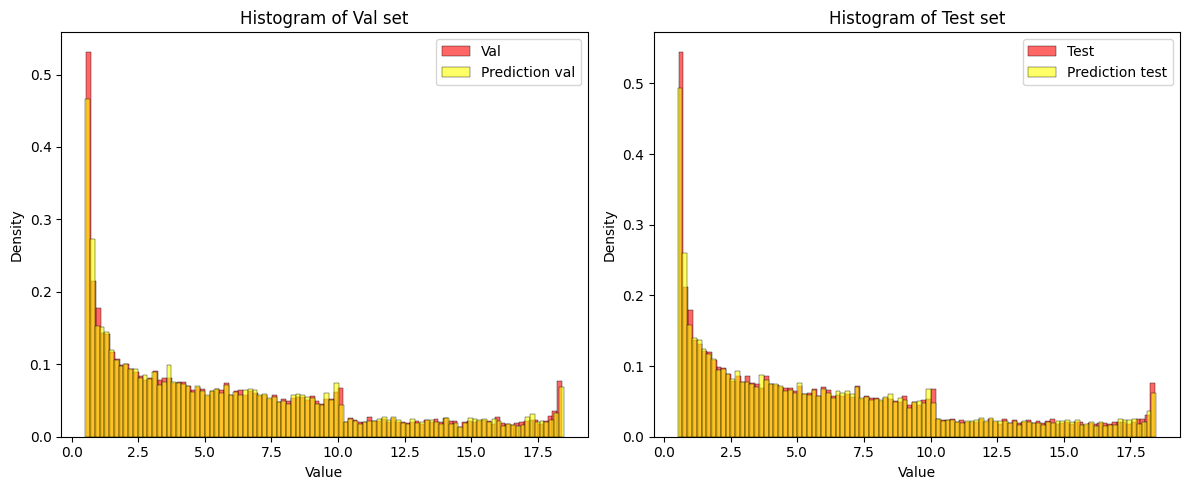

In [231]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(y_val, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Val')
sns.histplot(sm_list_outputs_val_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Prediction val')
#sns.histplot(list_outputs_val_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction train - mse: {round(avg_val_loss,3)}')
ax[0].set_title('Histogram of Val set')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')
ax[0].legend()


sns.histplot(y_test, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label='Test')
sns.histplot(sm_list_outputs_test_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Prediction test')
#sns.histplot(list_outputs_test_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction test - mse: {round(avg_test_loss,3)}')
ax[1].set_title('Histogram of Test set')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Density')
ax[1].legend()

plt.tight_layout()
plt.show()

In [232]:
torch.save(best_model_small.state_dict(), 'model_small_weights.pth')
torch.save(best_model_small, 'model_small.pth')

In [ ]:
model_small_loaded = MLP_small() 
model_small_loaded.load_state_dict(torch.load('model_small_weights.pth'))
model_small_loaded.eval()

# Plus petit modèle ~100 paramètres

In [223]:
class MLP_vsmall(nn.Module):
    def __init__(self):
        super(MLP_vsmall, self).__init__()
        self.fc1 = nn.Linear(10, 8)   
        self.fc2 = nn.Linear(8, 3)  
        self.fc3 = nn.Linear(3, 1)  

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)   
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01) 
        x = self.fc3(x)      
        return x

from torchinfo import summary
model_vsmall = MLP_vsmall()
summary(model_vsmall, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
MLP_vsmall                               [1, 1]                    --
├─Linear: 1-1                            [1, 8]                    88
├─Linear: 1-2                            [1, 3]                    27
├─Linear: 1-3                            [1, 1]                    4
Total params: 119
Trainable params: 119
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [237]:
import torch.optim as optim 
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

num_epochs = 500
lr = 0.1

model_vsmall = MLP_vsmall()
criterion = nn.MSELoss()  
optimizer = optim.Adam(model_vsmall.parameters(), lr=lr) 


start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
log_dir = 'run/log_' + str(start_time) + '_epochs_'+ str(num_epochs)+ '_lr_'+ str(lr)  + '_model_vsmall' 
writer = SummaryWriter(log_dir)

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model_vsmall.train() 
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_batches):
        optimizer.zero_grad()
        outputs = model_vsmall(inputs)
        targets = targets.view(-1, 1) 
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_batches)
    writer.add_scalar('Training Loss', avg_loss, epoch)

    model_vsmall.eval()  
    val_loss = 0.0
    
    with torch.no_grad():  
        for inputs, targets in val_batches:
            outputs = model_vsmall(inputs)
            outputs_clipped = np.clip(outputs, np.min(target), np.max(target))
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_batches)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_vsmall = model_vsmall
        print(f'Best model at epoch {epoch+1} with validation loss: {best_val_loss:.6f}')
    
    writer.add_scalar('Validation Loss', avg_val_loss, epoch)
    
    if epoch % 10 == 9:  
        print(f'Epoch [{epoch+1}/{num_epochs}],  Training Loss: {avg_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
        
writer.close()
print("Training finished.")

Best model at epoch 1 with validation loss: 1.490969
Best model at epoch 2 with validation loss: 0.057945
Best model at epoch 6 with validation loss: 0.047303
Best model at epoch 8 with validation loss: 0.044986
Epoch [10/500],  Training Loss: 0.074695, Validation Loss: 0.060855
Epoch [20/500],  Training Loss: 0.045800, Validation Loss: 0.053370
Best model at epoch 25 with validation loss: 0.026062
Epoch [30/500],  Training Loss: 0.046899, Validation Loss: 0.033449
Epoch [40/500],  Training Loss: 0.046535, Validation Loss: 0.056925
Best model at epoch 50 with validation loss: 0.023027
Epoch [50/500],  Training Loss: 0.045589, Validation Loss: 0.023027
Best model at epoch 58 with validation loss: 0.022544
Epoch [60/500],  Training Loss: 0.060878, Validation Loss: 0.032718
Epoch [70/500],  Training Loss: 0.038096, Validation Loss: 0.024277
Epoch [80/500],  Training Loss: 0.035586, Validation Loss: 0.025051
Epoch [90/500],  Training Loss: 0.035827, Validation Loss: 0.036761
Epoch [100/500

In [241]:
vsm_avg_loss_train, vsm_list_outputs_train_merge, vsm_list_outputs_clipped_train_merge = prediction_density(best_model_vsmall, train_batches, target, name ='Train')
vsm_avg_loss_val, vsm_list_outputs_val_merge, vsm_list_outputs_clipped_val_merge = prediction_density(best_model_vsmall, val_batches, target, name ='Val')
vsm_avg_loss_test, vsm_list_outputs_test_merge, vsm_list_outputs_clipped_test_merge = prediction_density(best_model_vsmall, test_batches, target, name ='Test')

Average MSE Train clipped 8.413416799157858e-05
Average MSE Val clipped 0.00028815382393077016
Average MSE Test clipped 0.0002810913138091564


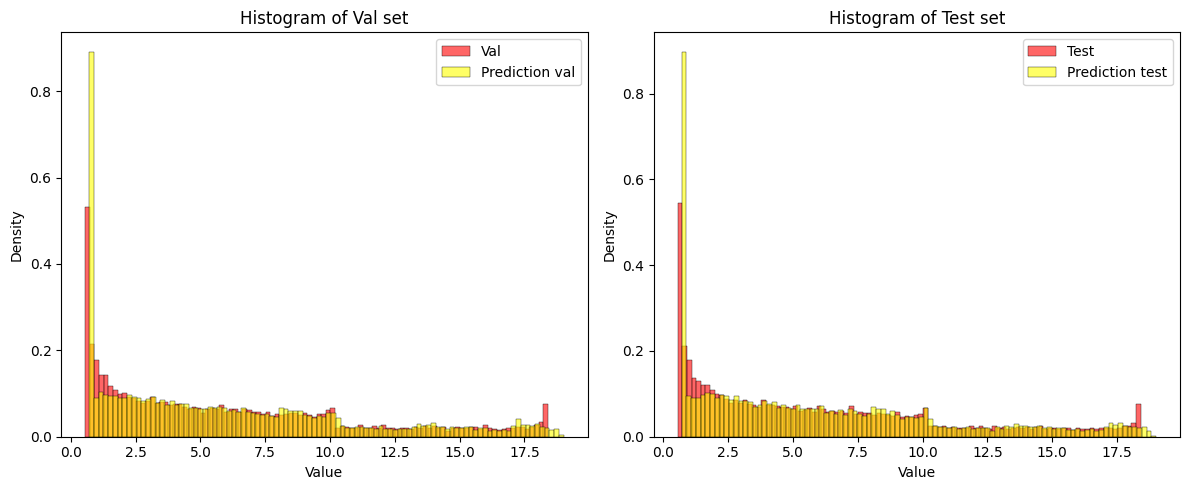

In [242]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(y_val, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Val')
sns.histplot(vsm_list_outputs_val_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[0], label='Prediction val')
#sns.histplot(list_outputs_val_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction train - mse: {round(avg_val_loss,3)}')
ax[0].set_title('Histogram of Val set')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')
ax[0].legend()


sns.histplot(y_test, bins=100, kde=False, color='red', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label='Test')
sns.histplot(vsm_list_outputs_test_merge, bins=100, kde=False, color='yellow', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Prediction test')
#sns.histplot(list_outputs_test_clipped_merge, bins=100, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6, ax=ax[1], label=f'Clipped prediction test - mse: {round(avg_test_loss,3)}')
ax[1].set_title('Histogram of Test set')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Density')
ax[1].legend()

plt.tight_layout()
plt.show()

In [243]:
torch.save(best_model_vsmall.state_dict(), 'model_vsmall_weights.pth')
torch.save(best_model_vsmall, 'model_vsmall.pth')

In [212]:
model_vsmall_loaded = MLP_vsmall() 
model_vsmall_loaded.load_state_dict(torch.load('model_vsmall_weights.pth'))
model_vsmall_loaded.eval()

C:\Users\lud44009\AppData\Local\Temp\ipykernel_14760\3720750886.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vsmall_loaded.load_state_dict(torch.load('model_vsm

MLP_vsmall(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

# Interprétabilité du MLP 10k 


  0%|          | 0/20000 [00:00<?, ?it/s]

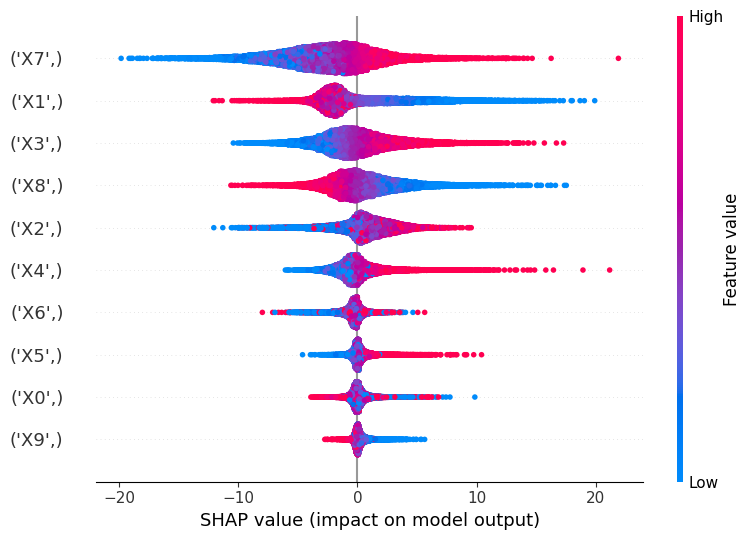

In [202]:
import shap 
def model_predict(inputs):
    with torch.no_grad():
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = model2predict(inputs)
        return outputs.view(-1).numpy()
    
model2predict=best_model
K = 10 
X_train_df = pd.DataFrame(X_train, columns=[data_df.columns])
X_test_df = pd.DataFrame(X_test, columns=[data_df.columns])
X_train_summary = shap.sample(X_train_df, K)
explainer = shap.KernelExplainer(model_predict, X_train_summary)

shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df)


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

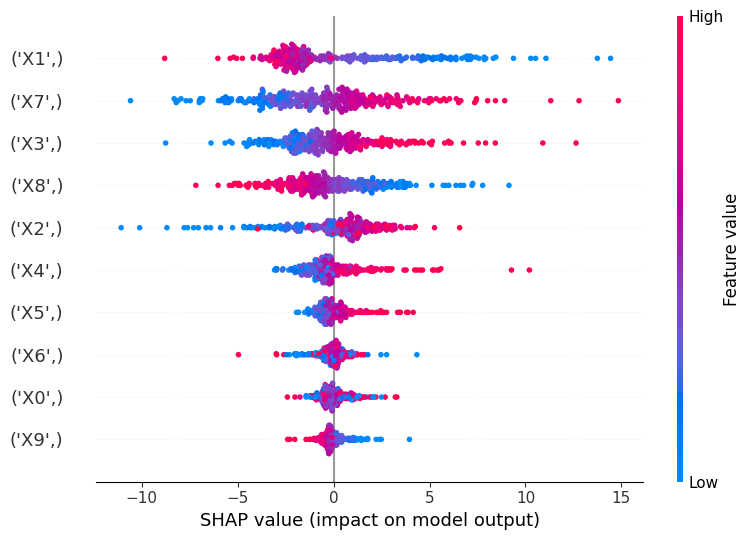

In [203]:
import shap 
def model_predict(inputs):
    with torch.no_grad():
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = model2predict(inputs)
        return outputs.view(-1).numpy()
    
model2predict=best_model
K = 300
X_train_df = pd.DataFrame(X_train, columns=[data_df.columns])
X_test_df = pd.DataFrame(X_test, columns=[data_df.columns])
X_train_summary = shap.sample(X_train_df, K)
explainer = shap.KernelExplainer(model_predict, X_train_summary)
X_test_summary = shap.sample(X_test_df, K)
shap_values = explainer.shap_values(X_test_summary)
shap.summary_plot(shap_values, X_test_summary)